In [36]:
from sensetity_calculator import calculate_session_sensetivity
from related_sessions_finder import fetch_related_sessions, index_data
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import json

In [12]:
data = pd.read_csv('data/ad_music_proccessed.csv', index_col=0)
data['sensetivity'] = data.apply(lambda session: calculate_session_sensetivity(session), axis=1)

In [13]:
device_data,ip_data,ck_data, ip_c_data, domain_data = index_data(data)
def score_session(session):
    x = fetch_related_sessions(session, device_data,ip_data,ck_data, ip_c_data, domain_data)
    session_score =  session.sensetivity + sum(x.sensetivity * x.relevance)
    return session_score

In [14]:
data['session_score'] = data.apply(lambda session: score_session(session),axis=1)


In [15]:
data.to_csv('data/scored_sessions.csv')

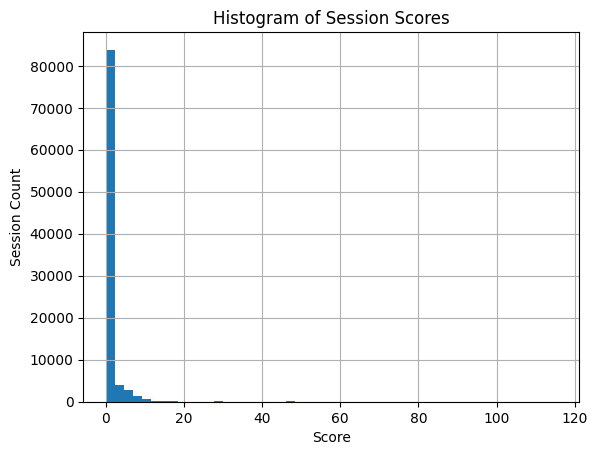

In [20]:
data.session_score.hist(bins=50)
plt.title('Histogram of Session Scores')
plt.ylabel('Session Count')
plt.xlabel('Score')
plt.show()

In [21]:
data.session_score.describe()

count    93645.000000
mean         1.303772
std          5.424941
min          0.001000
25%          0.054000
50%          0.134000
75%          0.958000
max        115.350000
Name: session_score, dtype: float64

The 75th Percentile of score is still below 1, meaning most of the are not sensetive sessions (include senstive commands).
By selecting a score threshold we can control the amount of sessions flagged as malicious.
I will use the the maximal number that catches all fund extraction, info steal, physical theft and most of the ato.
By 'catches' I mean the following : contains at least one session with score > threshold where user id is in the pool of affected accounts.

In [42]:
with open('attacks/affected_users.json','r') as f:
    affected_accounts = json.load(f)
affected_accounts.pop('phising',None)
for key,val in affected_accounts.items():
    print(f"Attack Type: {key}, Num Affected Accounts: {len(val)}")


Attack Type: funds_extraction, Num Affected Accounts: 20
Attack Type: ato, Num Affected Accounts: 58
Attack Type: information_theft, Num Affected Accounts: 13
Attack Type: theft, Num Affected Accounts: 10


In [61]:
found_accounts = 0
thresholds = np.linspace(0,10,100)
results = []
for th in thresholds:
    th_data = data[data.session_score >= th]
    accounts = th_data.user_id.unique()
    results.append({
         'threshold':th,
         'total_sessions_found':th_data.shape[0],
         'total_accounts_found':len(accounts),
         'fund_extraction_found':len(set(accounts).intersection(set(affected_accounts['funds_extraction']))),
         'information_theft_found':len(set(accounts).intersection(set(affected_accounts['information_theft']))),
         'theft_found':len(set(accounts).intersection(set(affected_accounts['theft']))),
         'ato_found':len(set(accounts).intersection(set(affected_accounts['ato'])))
    })
results = pd.DataFrame(results,columns=['threshold','total_sessions_found','total_accounts_found','fund_extraction_found','information_theft_found','theft_found','ato_found'])
results

,threshold,total_sessions_found,total_accounts_found,fund_extraction_found,information_theft_found,theft_found,ato_found
0,0.00000,93645,2430,20,13,10,58
1,0.10101,54970,1988,20,13,10,58
2,0.20202,36548,1390,20,13,10,58
3,0.30303,30510,1096,20,13,10,58
4,0.40404,29000,1023,20,13,10,58
...,...,...,...,...,...,...,...
95,9.59596,1659,93,20,12,10,55
96,9.69697,1641,91,19,12,9,53
97,9.79798,1641,91,19,12,9,53
98,9.89899,1600,88,19,12,9,53


In [69]:
th = results[results.fund_extraction_found.eq(len(affected_accounts['funds_extraction']))]
th = th[th.information_theft_found.eq(len(affected_accounts['information_theft']))]
th = th[th.theft_found.eq(len(affected_accounts['theft']))]
th = th[th.ato_found.eq(len(affected_accounts['ato']))]
threshold = th.threshold.max()
r = results.loc[th.threshold.idxmax()]

account_catch_Ratio = r.total_accounts_found / data.user_id.nunique()
session_catch_Ratio = r.total_sessions_found / data.shape[0]


print(f"Maximal Threshold : {threshold:.2f}")
print("Above this session score some affected accounts wont be flagged.\n")
print(r,'\n')
print(f"{account_catch_Ratio*100:.1f}% of all accounts were flagged as affected by a malicous session")
print(f"{session_catch_Ratio*100:.1f}% of all sessions were flagged as malicous")

Maximal Threshold : 5.56
Above this session score some affected accounts wont be flagged.

threshold                     5.555556
total_sessions_found       4212.000000
total_accounts_found        197.000000
fund_extraction_found        20.000000
information_theft_found      13.000000
theft_found                  10.000000
ato_found                    58.000000
Name: 55, dtype: float64 

8.1% of all accounts were flagged as affected by a malicous session
4.5% of all sessions were flagged as malicous
